--- Starting Figure Generation ---

Loading Cultivated1st (16 Cultigens) data...
Loading data from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated1st_combined/original_pca_scores_and_class_labels_cultivated1st.h5
Loading PCA parameters from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated1st_combined/leaf_pca_model_parameters_cultivated1st.h5
Data loaded for 

Loading Cultivated2nd (19 Cultigens) data...
Loading data from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated2nd_combined/original_pca_scores_and_class_labels_cultivated2nd.h5
Loading PCA parameters from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated2nd_combined/leaf_pca_model_parameters_cultivated2ND.h5
Data loaded for 

Combining data and performing new PCA for collection-based morphospace...
Performing PCA on combined data...

Calculating variety shift arrow data...
Found 16 common classes for arrow plot.

--- Generating Combined Two-Row Figure ---
Row 1 Main Morphospace Height: 3.67 inches

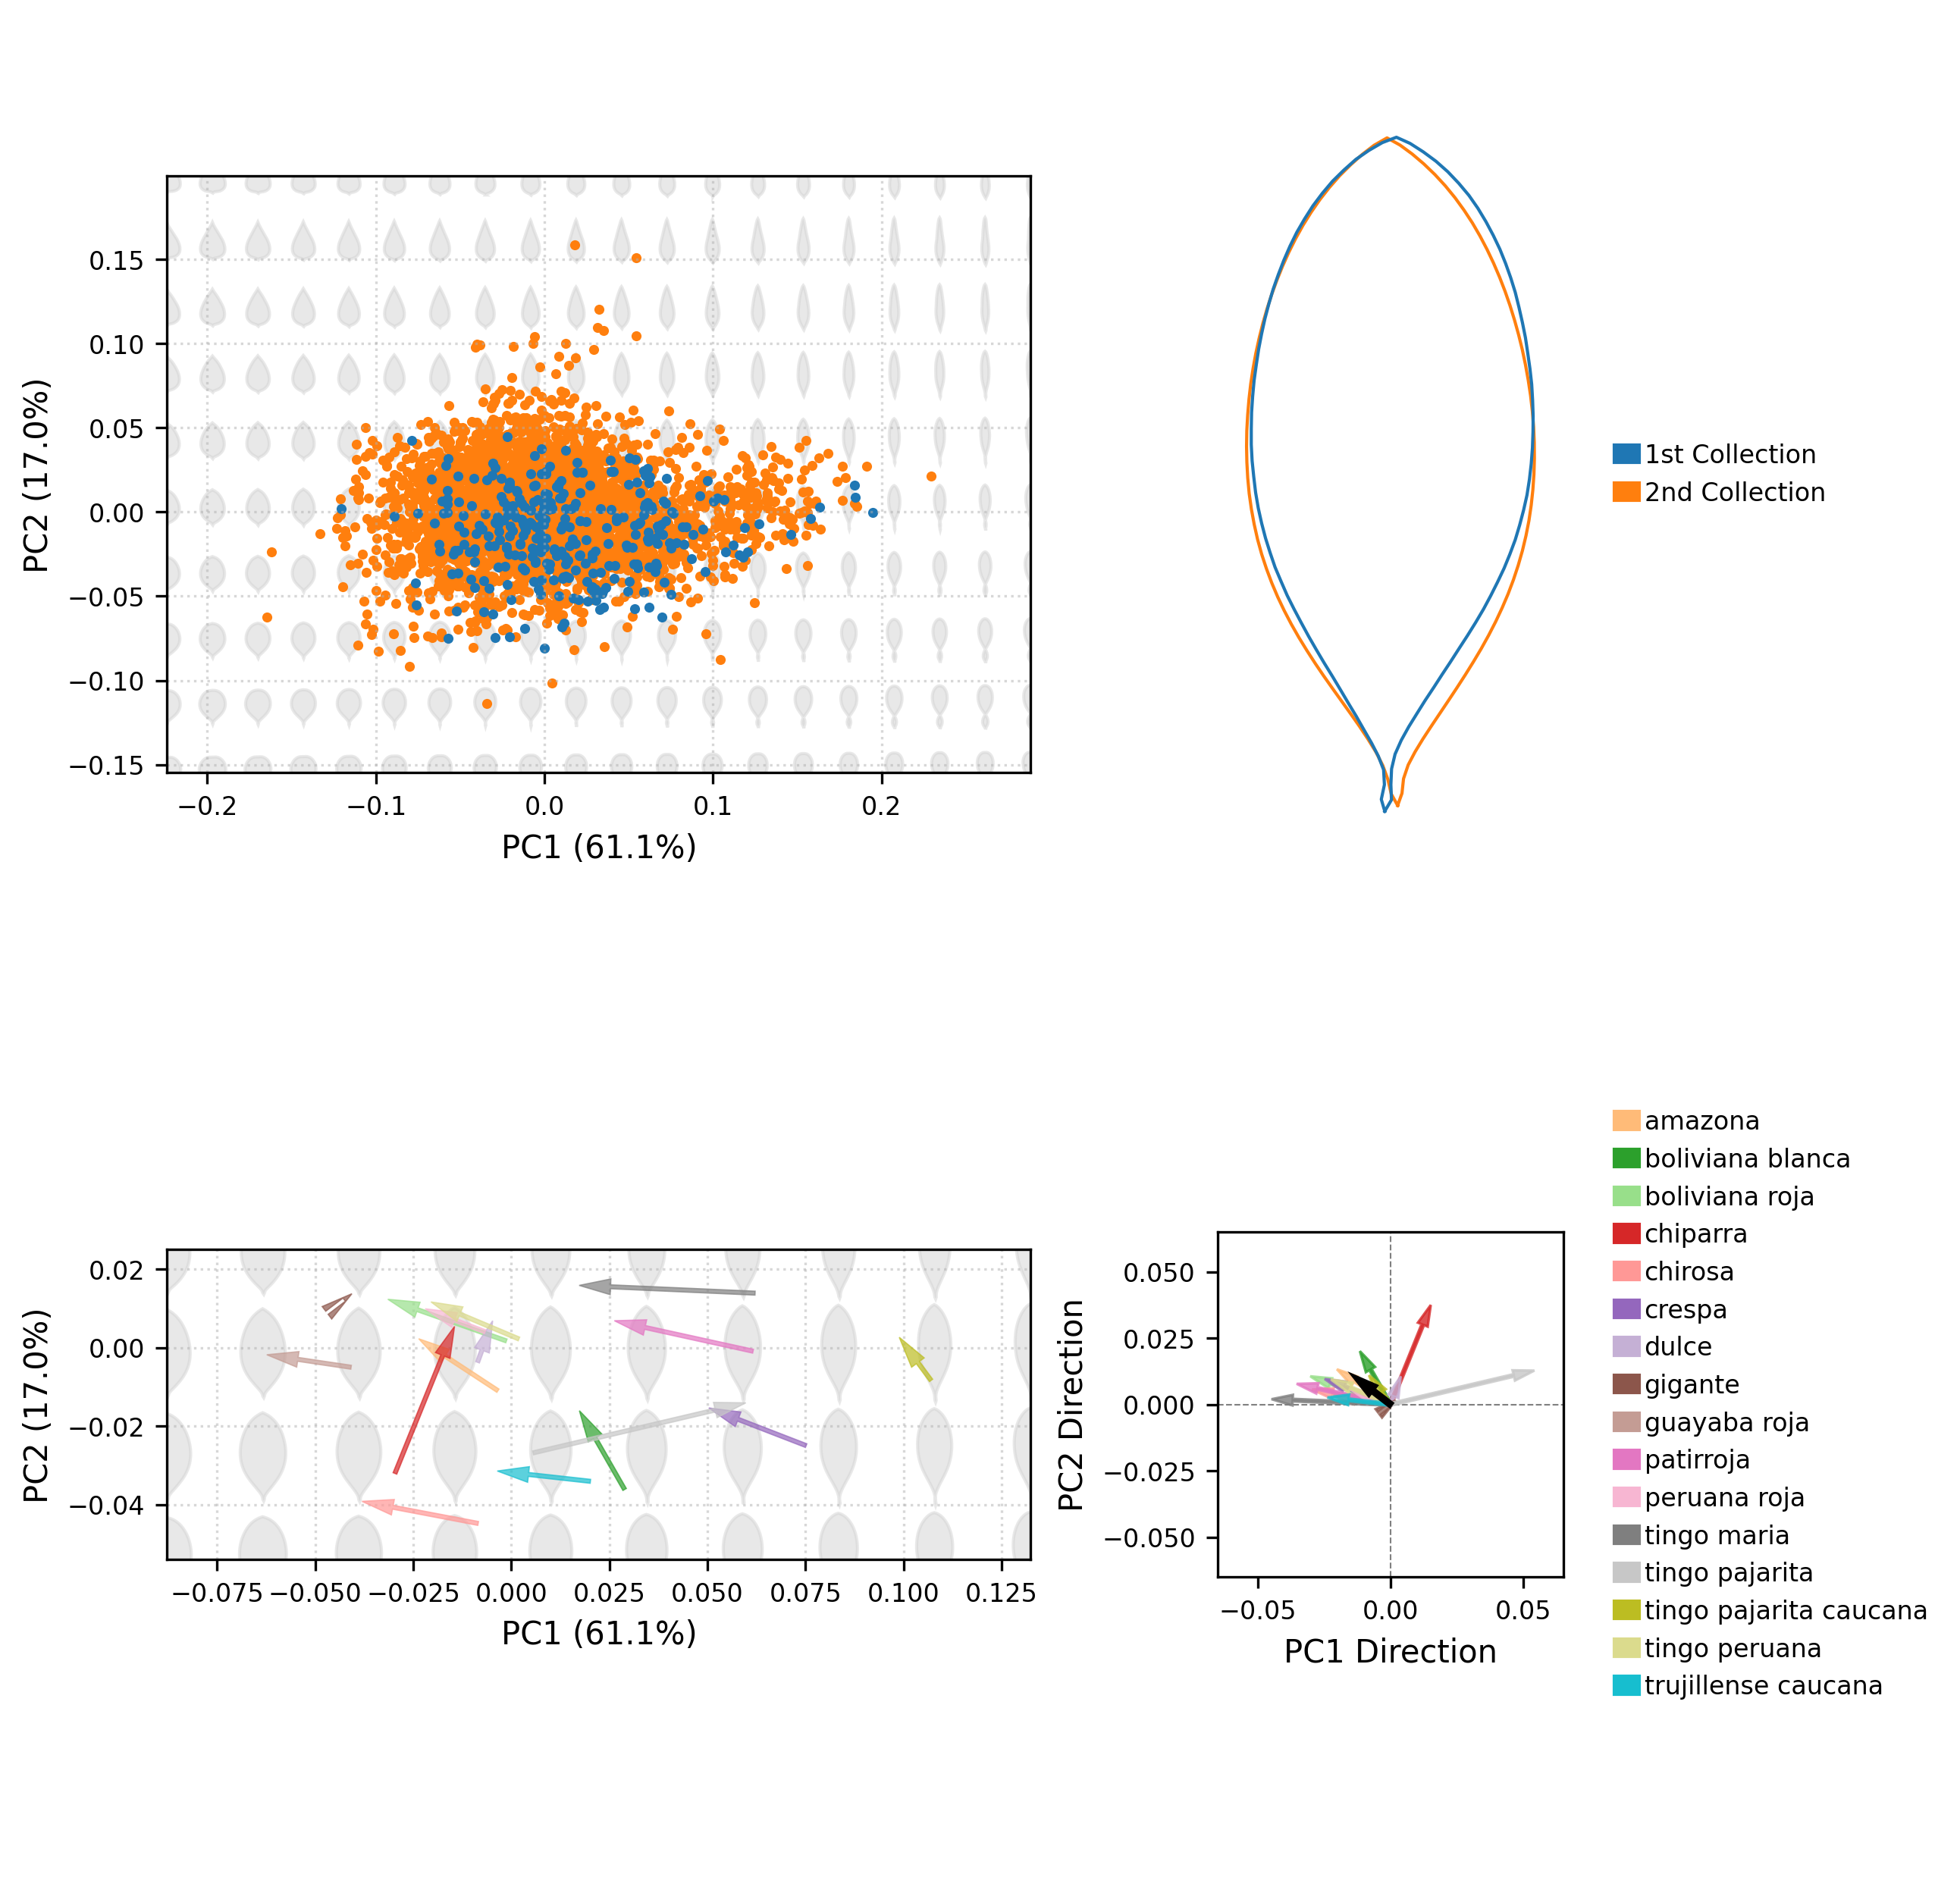

In [33]:
#######################
### LOAD IN MODULES ###
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from sklearn.decomposition import PCA
from matplotlib.patches import Patch # For simplified legend patches

# Ensure consistent plotting style for publication
plt.style.use('seaborn-v0_8-deep')

############################
### GLOBAL CONFIGURATION ###
############################

# --- File Paths ---
# Base directory for data (relative to notebooks/)
DATA_BASE_DIR = "../data/CULTIVATED2ND/" # Points to COCA_PROJECT/data/CULTIVATED2ND/

# Morphometrics output subdirectories for the 16/19 cultigen datasets
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST_16CULTIGENS = "03_morphometrics_output_cultivated1st_combined/"
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED2ND_19CULTIGENS = "03_morphometrics_output_cultivated2nd_combined/"

# Filenames for HDF5 outputs (specific to 16/19 cultigen data)
PCA_PARAMS_FILENAME_CULTIVATED1ST = "leaf_pca_model_parameters_cultivated1st.h5"
PCA_SCORES_LABELS_FILENAME_CULTIVATED1ST = "original_pca_scores_and_class_labels_cultivated1st.h5"

PCA_PARAMS_FILENAME_CULTIVATED2ND = "leaf_pca_model_parameters_cultivated2ND.h5" # Corrected filename based on previous run
PCA_SCORES_LABELS_FILENAME_CULTIVATED2ND = "original_pca_scores_and_class_labels_cultivated2nd.h5"


# Output directory for figures (relative to notebooks/)
FIGURES_OUTPUT_DIR = "../figures/" # Points to COCA_PROJECT/figures/
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

# --- Figure Parameters ---
PAGE_WIDTH_INCHES = 8.5
DPI = 300

# NUM_MORPHOSPACES = 2 # Original: 2 rows for the morphospaces. Will change this to 1 for the new combined plot.

# General font sizes
AXIS_LABEL_FONTSIZE = 10
AXIS_TICK_FONTSIZE = 8
LEGEND_FONTSIZE = 8 # Smaller for the narrow legend column

# --- Plotting Specifics for Morphospace ---
EIGENLEAF_SCALE_FACTOR = 0.08 # Reverted to 0.08
EIGENLEAF_COLOR = "lightgray"
EIGENLEAF_ALPHA = 0.5
POINT_SIZE = 10
POINT_ALPHA = 1
POINT_LINEWIDTH = 0

# --- Mean Outlines Plotting ---
MEAN_OUTLINE_LINEWIDTH = 1.0
MEAN_OUTLINE_SCALE_FACTOR = 1.0 # This factor influences overall size, adjust if needed
SHAPE_EXAGGERATION_FACTOR = 1.0 # This factor influences how much deviation from mean is shown

# NEW: Margin factor for plots to prevent clipping of points/eigenleaves
PLOT_MARGIN_FACTOR = 0.15

# Number of landmarks and dimensions (consistent for all datasets)
NUM_DIMENSIONS = 2

# NEW: Base values for arrow head dimensions in translated arrows plot
# These act as *minimums* for dynamic scaling, ensuring visibility
# Adjusted these slightly for potentially better visual minimums
BASE_ARROW_HEAD_WIDTH = 0.004 # A small absolute value
BASE_ARROW_HEAD_LENGTH = 0.008 # A small absolute value


# Define column width ratios as discussed: Main (5), Outlines (2), Legend (1)
COL_MAIN_MORPHOSPACE_RATIO = 5
COL_MEAN_OUTLINES_RATIO = 2
COL_SIMPLE_LEGEND_RATIO = 1
TOTAL_COL_RATIO = COL_MAIN_MORPHOSPACE_RATIO + COL_MEAN_OUTLINES_RATIO + COL_SIMPLE_LEGEND_RATIO

# *** GLOBAL CONFIGURATION FOR ARROW PLOT HEIGHT ***
ARROW_PLOT_HEIGHT_SCALE_FACTOR = 2.0 # Factor to scale up the height of the arrow plot

# --- Global Class Lists and Color Palette ---

# Shared 16 cultigen names (alphabetical order as provided)
SHARED_16_CULTIGENS = [
    'amazona', 'boliviana blanca', 'boliviana roja', 'chiparra', 'chirosa',
    'crespa', 'dulce', 'gigante', 'guayaba roja', 'patirroja',
    'peruana roja', 'tingo maria', 'tingo pajarita', 'tingo pajarita caucana',
    'tingo peruana', 'trujillense caucana'
]

# Additional classes for the 2nd dataset, with their display names
ADDITIONAL_CULTIGENS_MAP = {
    "BON": "boliviana negra",
    "DES": "desconocido",
    "POM": "pomarosa"
}
ADDITIONAL_CULTIGENS_RAW_NAMES = list(ADDITIONAL_CULTIGENS_MAP.keys())
ADDITIONAL_CULTIGENS_DISPLAY_NAMES = list(ADDITIONAL_CULTIGENS_MAP.values())


# Combined list of all 19 unique classes for consistent color mapping
# Sort raw names to ensure the palette is consistently generated
ALL_19_CULTIGENS_RAW_ORDERED = sorted(SHARED_16_CULTIGENS + ADDITIONAL_CULTIGENS_RAW_NAMES)
# Sort display names for legend consistency
ALL_19_CULTIGENS_DISPLAY_ORDERED = sorted(SHARED_16_CULTIGENS + ADDITIONAL_CULTIGENS_DISPLAY_NAMES)


# Dynamically create a palette for all 19 classes using 'tab20' (good for ~20 distinct colors)
PALETTE = sns.color_palette('tab20', n_colors=len(ALL_19_CULTIGENS_RAW_ORDERED))
# Map raw class names to colors
CLASS_COLORS_MAP = {cls: PALETTE[i] for i, cls in enumerate(ALL_19_CULTIGENS_RAW_ORDERED)}

# Create a mapping from raw names to display names for labels
CLASS_DISPLAY_NAMES_MAP = {cls: cls for cls in SHARED_16_CULTIGENS}
CLASS_DISPLAY_NAMES_MAP.update(ADDITIONAL_CULTIGENS_MAP) # Add the remapped names


# NEW: Collection specific colors and display names for plotting
COLLECTION_COLORS_MAP = {
    'Collection_1st': '#1f77b4', # A default blue
    'Collection_2nd': '#ff7f0e'  # A default orange
}

# NEW: Collection display names for legend and plot titles
COLLECTION_DISPLAY_NAMES_MAP = {
    'Collection_1st': '1st Collection',
    'Collection_2nd': '2nd Collection'
}


#########################
### HELPER FUNCTIONS ###
#########################

def load_morphometrics_data_from_h5(base_dir, morphometrics_subdir, pca_params_filename, pca_scores_labels_filename):
    """
    Loads PCA scores, class labels, original flattened coordinates,
    and PCA model parameters for a given dataset from HDF5 files,
    and calculates average shapes per class.
    """
    output_dir = os.path.join(base_dir, morphometrics_subdir)

    pca_scores_labels_path = os.path.join(output_dir, pca_scores_labels_filename)
    pca_params_path = os.path.join(output_dir, pca_params_filename)

    data = {}

    print(f"Loading data from {pca_scores_labels_path}")
    with h5py.File(pca_scores_labels_path, 'r') as f:
        data['pc_scores'] = f['pca_scores'][:]
        data['class_labels'] = f['class_labels'][:].astype(str)
        data['original_flattened_coords'] = f['original_flattened_coords'][:]

    print(f"Loading PCA parameters from {pca_params_path}")
    with h5py.File(pca_params_path, 'r') as f:
        data['pca_components'] = f['components'][:]
        data['pca_mean'] = f['mean'][:]
        data['pca_explained_variance_ratio'] = f['explained_variance_ratio'][:]
        data['num_pca_components'] = f.attrs['n_components']

    data['num_dimensions'] = NUM_DIMENSIONS # Use global constant
    data['num_landmarks'] = data['original_flattened_coords'].shape[1] // data['num_dimensions']

    # Calculate and store average shapes per class
    average_shapes = {}
    unique_classes = np.unique(data['class_labels'])
    for cls in unique_classes:
        class_indices = (data['class_labels'] == cls)
        class_coords_flat = data['original_flattened_coords'][class_indices]
        class_coords_3d = class_coords_flat.reshape(-1, data['num_landmarks'], data['num_dimensions'])
        avg_shape = np.mean(class_coords_3d, axis=0)
        average_shapes[cls] = avg_shape
    data['average_shapes_by_class'] = average_shapes # Corrected line: assign the dictionary
    print(f"Data loaded for {os.path.basename(morphometrics_subdir)}")
    return data

def plot_morphospace_panel(ax_main, data, hue_labels, hue_palette, hue_order=None,
                           pc1_intervals=20, pc2_intervals=6, title=None, zorder_map=None,
                           plot_scatter=True, plot_arrows_data=None, crop_to_arrows=False):
    """
    Plots a single morphospace panel including scatter plot and eigenleaf grid.
    Uses generic hue_labels and hue_palette for flexibility.
    Axis limits are determined independently for each panel.
    Allows independent control over eigenleaf intervals.
    Added options to control scatter plotting and add arrows.

    Args:
        ax_main (matplotlib.axes.Axes): The main axes object for the scatter plot.
        data (dict): Dictionary containing 'pc_scores' (numpy array) for PC1 and PC2.
        hue_labels (numpy.ndarray or list): Labels to use for hue mapping in the scatter plot.
        hue_palette (dict or list): Color palette for hue mapping.
        hue_order (list, optional): Order for plotting hue categories. Defaults to None.
        pc1_intervals (int): Number of intervals for PC1 in the eigenleaf grid. Defaults to 20.
        pc2_intervals (int): Number of intervals for PC2 in the eigenleaf grid. Defaults to 6.
        title (str, optional): Title of the plot. Defaults to None.
        zorder_map (dict, optional): Dictionary mapping hue labels to zorder values. Defaults to None.
        plot_scatter (bool): If True, plots individual data points. Defaults to True.
        plot_arrows_data (dict, optional): If provided, plots arrows.
                                            Expected format: {'class_label': {'start_pc': [pc1, pc2], 'end_pc': [pc1, pc2]}, ...}
        crop_to_arrows (bool): If True, axis limits will be set tightly around arrow start/end points.
    """
    
    df_plot = pd.DataFrame({
        'PC1': data['pc_scores'][:, 0],
        'PC2': data['pc_scores'][:, 1],
        'HueColumn': hue_labels # Generic column for hue
    })

    # Initialize min/max for plotting limits
    pc1_min_plot, pc1_max_plot = np.inf, -np.inf
    pc2_min_plot, pc2_max_plot = np.inf, -np.inf

    if crop_to_arrows and plot_arrows_data:
        # If cropping to arrows, only consider arrow coordinates for limits
        all_arrow_coords_pc1 = []
        all_arrow_coords_pc2 = []
        for arrow_info in plot_arrows_data.values():
            all_arrow_coords_pc1.append(arrow_info['start_pc'][0])
            all_arrow_coords_pc1.append(arrow_info['end_pc'][0])
            all_arrow_coords_pc2.append(arrow_info['start_pc'][1])
            all_arrow_coords_pc2.append(arrow_info['end_pc'][1])
        
        if all_arrow_coords_pc1 and all_arrow_coords_pc2:
            pc1_min_data = np.min(all_arrow_coords_pc1)
            pc1_max_data = np.max(all_arrow_coords_pc1)
            pc2_min_data = np.min(all_arrow_coords_pc2)
            pc2_max_data = np.max(all_arrow_coords_pc2)
        else: # Fallback if no arrow data despite crop_to_arrows being true
            pc1_min_data, pc1_max_data = df_plot['PC1'].min(), df_plot['PC1'].max()
            pc2_min_data = df_plot['PC2'].min()
            pc2_max_data = df_plot['PC2'].max()
    else:
        # Default behavior: use all scatter data for limits
        pc1_min_data, pc1_max_data = df_plot['PC1'].min(), df_plot['PC1'].max()
        pc2_min_data = df_plot['PC2'].min()
        pc2_max_data = df_plot['PC2'].max()

    pc1_range = pc1_max_data - pc1_min_data
    pc2_range = pc2_max_data - pc2_min_data

    pc1_min_plot = pc1_min_data - pc1_range * PLOT_MARGIN_FACTOR
    pc1_max_plot = pc1_max_data + pc1_range * PLOT_MARGIN_FACTOR
    pc2_min_plot = pc2_min_data - pc2_range * PLOT_MARGIN_FACTOR
    pc2_max_plot = pc2_max_data + pc2_range * PLOT_MARGIN_FACTOR

    ax_main.set_xlim(pc1_min_plot, pc1_max_plot)
    ax_main.set_ylim(pc2_min_plot, pc2_max_plot)

    # Plot inverse eigenleaves (the background grid shapes) first
    pca_components_2d = data['pca_components'][:2, :]
    pca_mean_flat = data['pca_mean']

    PC1_vals = np.linspace(pc1_min_plot, pc1_max_plot, pc1_intervals)
    PC2_vals = np.linspace(pc2_min_plot, pc2_max_plot, pc2_intervals)

    for i in PC1_vals:
        for j in PC2_vals:
            reconstructed_flat_shape = (np.array([i, j]) @ pca_components_2d) + pca_mean_flat
            reconstructed_shape_2d = reconstructed_flat_shape.reshape(data['num_landmarks'], data['num_dimensions'])
            ax_main.fill(reconstructed_shape_2d[:, 0] * EIGENLEAF_SCALE_FACTOR + i,
                         reconstructed_shape_2d[:, 1] * EIGENLEAF_SCALE_FACTOR + j,
                         color=EIGENLEAF_COLOR, alpha=EIGENLEAF_ALPHA, zorder=-1) # Eigenleaves are always in background

    # --- PLOT SCATTER POINTS SEPARATELY FOR Z-ORDER CONTROL ---
    if plot_scatter:
        # Determine the plotting order based on hue_order and zorder_map
        # If no hue_order, get unique labels and sort them by zorder if map exists
        if hue_order is None:
            unique_labels = sorted(df_plot['HueColumn'].unique())
            if zorder_map:
                unique_labels.sort(key=lambda x: zorder_map.get(x, 0)) # Sort by zorder if provided
        else:
            unique_labels = hue_order # Use provided hue_order as is, assuming it defines the order


        for label in unique_labels:
            subset_df = df_plot[df_plot['HueColumn'] == label]
            current_zorder = zorder_map.get(label, 2) if zorder_map else 2 # Get zorder for this specific label
            current_color = hue_palette.get(label, 'black') # Get color for this label

            ax_main.scatter(
                x=subset_df['PC1'],
                y=subset_df['PC2'],
                s=POINT_SIZE,
                linewidth=POINT_LINEWIDTH,
                alpha=POINT_ALPHA,
                color=current_color, # Use scalar color
                zorder=current_zorder # Use scalar zorder
            )
    # --- END SCATTER PLOTTING ---

    # --- PLOT ARROWS ---
    if plot_arrows_data:
        # Define base arrow properties relative to the plot's range
        x_range = ax_main.get_xlim()[1] - ax_main.get_xlim()[0]
        y_range = ax_main.get_ylim()[1] - ax_main.get_ylim()[0]
        
        # Use a fraction of the smaller range for head size to keep it proportional
        effective_range = min(x_range, y_range)
        
        # Percentage of the effective range for arrow head dimensions
        ARROW_HEAD_WIDTH_FACTOR = 0.015 # % of effective range
        ARROW_HEAD_LENGTH_FACTOR = 0.03 # % of effective range

        # Dynamic calculation based on effective_range, with a minimum value
        arrow_head_width = max(BASE_ARROW_HEAD_WIDTH, effective_range * ARROW_HEAD_WIDTH_FACTOR)
        arrow_head_length = max(BASE_ARROW_HEAD_LENGTH, effective_range * ARROW_HEAD_LENGTH_FACTOR)
        
        ARROW_LINEWIDTH = 0.4
        ARROW_ALPHA = 0.7

        # Get the keys for consistent ordering, useful if you want a specific drawing order
        sorted_arrow_labels = sorted(plot_arrows_data.keys(), key=lambda x: CLASS_DISPLAY_NAMES_MAP.get(x, x))


        for label in sorted_arrow_labels:
            arrow_info = plot_arrows_data[label]
            start_pc = arrow_info['start_pc']
            end_pc = arrow_info['end_pc']
            arrow_color = hue_palette.get(label, 'black') # Use cultigen color for arrow

            # Draw the arrow directly from start to end
            dx = end_pc[0] - start_pc[0]
            dy = end_pc[1] - start_pc[1]

            ax_main.arrow(start_pc[0], start_pc[1], dx, dy,
                          head_width=arrow_head_width, head_length=arrow_head_length,
                          fc=arrow_color, ec=arrow_color, linewidth=ARROW_LINEWIDTH, alpha=ARROW_ALPHA,
                          length_includes_head=True, zorder=3) # Arrows on top

    # --- END PLOT ARROWS ---

    # Set axis labels with explained variance from the first two PCs
    exp_var_pc1 = data['pca_explained_variance_ratio'][0] * 100
    exp_var_pc2 = data['pca_explained_variance_ratio'][1] * 100

    ax_main.set_xlabel(f"PC1 ({exp_var_pc1:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.set_ylabel(f"PC2 ({exp_var_pc2:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.set_aspect('equal', adjustable='box')
    ax_main.set_facecolor('white')
    ax_main.grid(True, linestyle=':', alpha=0.5)
    if title: # This conditional will prevent titles from being set if title is None
        ax_main.set_title(title, fontsize=AXIS_LABEL_FONTSIZE + 2)


def plot_mean_outlines(ax, average_shapes_dict, colors_map, display_name_map, overall_mean_shape_flat, num_landmarks, num_dimensions, plot_order=None):
    """
    Plots the mean leaf outline for each class, with exaggeration, based on a provided dictionary
    of average shapes and an overall mean shape.
    Supports a custom plot_order for mean outlines.
    """
    ax.clear()
    ax.set_axis_off()

    if not average_shapes_dict:
        return

    overall_mean_shape_2d = overall_mean_shape_flat.reshape(num_landmarks, num_dimensions)

    exaggerated_shapes_to_plot = {} # Store exaggerated shapes temporarily

    # 1. Calculate all exaggerated shapes and find their max extent
    max_exaggerated_extent = 0
    # Use custom plot_order if provided, otherwise sort keys for consistency
    classes_to_plot = plot_order if plot_order is not None else sorted(average_shapes_dict.keys(), key=lambda x: display_name_map.get(x, x))


    for cls in classes_to_plot:
        if cls in average_shapes_dict: # Ensure the class has a defined average shape
            avg_shape_2d = average_shapes_dict[cls]

            # Exaggerate the shape difference from the overall mean
            exaggerated_shape = avg_shape_2d + SHAPE_EXAGGERATION_FACTOR * (avg_shape_2d - overall_mean_shape_2d)

            # Center the exaggerated shape to calculate its extent for scaling
            centered_exaggerated_shape = exaggerated_shape - np.mean(exaggerated_shape, axis=0)
            max_exaggerated_extent = max(max_exaggerated_extent, np.max(np.abs(centered_exaggerated_shape)))

            exaggerated_shapes_to_plot[cls] = centered_exaggerated_shape # Store centered for plotting

    if max_exaggerated_extent == 0: max_exaggerated_extent = 1 # Avoid division by zero


    # Determine the bounding box for all scaled mean shapes to set the limits of the subplot
    all_scaled_x = []
    all_scaled_y = []

    # 2. Plot the (now exaggerated and pre-centered) shapes
    # Iterate based on the desired plot_order
    for cls in classes_to_plot:
        if cls in exaggerated_shapes_to_plot:
            centered_exaggerated_shape = exaggerated_shapes_to_plot[cls]
            color = colors_map.get(cls, 'black') # Get color using the raw class name

            # Scale the pre-centered shape based on the max extent found across ALL exaggerated shapes
            final_scaled_shape = (centered_exaggerated_shape / max_exaggerated_extent) * MEAN_OUTLINE_SCALE_FACTOR

            # Collect points for setting limits
            all_scaled_x.extend(final_scaled_shape[:, 0])
            all_scaled_y.extend(final_scaled_shape[:, 1])

            # Use ax.plot for outlines, with solid color and defined linewidth
            ax.plot(final_scaled_shape[:, 0], final_scaled_shape[:, 1],
                     color=color, linewidth=MEAN_OUTLINE_LINEWIDTH, zorder=2) # zorder for outlines
    
    # Set uniform limits for the mean outlines plot to ensure consistent scaling
    if all_scaled_x and all_scaled_y:
        x_min, x_max = np.min(all_scaled_x), np.max(all_scaled_x)
        y_min, y_max = np.min(all_scaled_y), np.max(all_scaled_y)
        
        # Add some padding
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)
        ax.set_aspect('equal', adjustable='box')

def plot_translated_arrows(ax, arrow_data, colors_map, overall_vector_color='black', title=None):
    """
    Plots arrows translated so their tails are at the origin (0,0).
    Also plots an overall mean vector in a distinct color. Arrowhead sizes are
    dynamically scaled based on the maximum vector magnitude in the plot,
    with a minimum size defined by global constants.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        arrow_data (dict): Dictionary with 'class_label': {'start_pc': [pc1, pc2], 'end_pc': [pc1, pc2]}.
        colors_map (dict): Mapping from class labels to colors.
        overall_vector_color (str): Color for the summed overall vector.
        title (str, optional): Title for the subplot.
    """
    ax.clear()
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':', alpha=0.0)

    vectors = {}
    magnitudes = []

    # Calculate all vectors and their magnitudes
    for label, info in arrow_data.items():
        dx = info['end_pc'][0] - info['start_pc'][0]
        dy = info['end_pc'][1] - info['start_pc'][1]
        vectors[label] = (dx, dy)
        mag = np.sqrt(dx**2 + dy**2)
        magnitudes.append(mag)

    # Calculate the MEAN vector instead of the SUM vector
    num_vectors = len(vectors)
    if num_vectors > 0:
        mean_dx = np.sum([v[0] for v in vectors.values()]) / num_vectors
        mean_dy = np.sum([v[1] for v in vectors.values()]) / num_vectors
        mean_magnitude = np.sqrt(mean_dx**2 + mean_dy**2)
        magnitudes.append(mean_magnitude)
    else:
        mean_dx, mean_dy, mean_magnitude = 0, 0, 0

    # Determine the maximum magnitude to scale arrowheads
    max_magnitude = max(magnitudes) if magnitudes else 0.1 # Default if no arrows
    if max_magnitude < 1e-6: # Prevent extremely small values causing huge heads
        max_magnitude = 0.1 # Fallback to a reasonable value if vectors are almost zero


    # Dynamically determine arrow head and line width based on max_magnitude
    # These factors are percentages of the max_magnitude
    # Adjust these factors as needed to get the desired visual appearance
    ARROW_HEAD_WIDTH_FACTOR = 0.05    # e.g., 5% of max magnitude
    ARROW_HEAD_LENGTH_FACTOR = 0.1    # e.g., 10% of max magnitude
    INDIVIDUAL_ARROW_LINEWIDTH = 0.8
    MEAN_ARROW_LINEWIDTH = 1.5 # Mean vector is slightly thicker

    # Use max() with global BASE values to ensure a minimum arrowhead size
    arrow_head_width = max(BASE_ARROW_HEAD_WIDTH, max_magnitude * ARROW_HEAD_WIDTH_FACTOR) # Ensure min size
    arrow_head_length = max(BASE_ARROW_HEAD_LENGTH, max_magnitude * ARROW_HEAD_LENGTH_FACTOR) # Ensure min size

    # Plot individual arrows
    for label in sorted(vectors.keys()):
        dx, dy = vectors[label]
        color = colors_map.get(label, 'grey')
        # Only plot arrows if they have some length, to avoid tiny dots
        if np.sqrt(dx**2 + dy**2) > (max_magnitude * 0.001): # Arbitrary small threshold for plotting
            ax.arrow(0, 0, dx, dy,
                     head_width=arrow_head_width, head_length=arrow_head_length,
                     fc=color, ec=color, linewidth=INDIVIDUAL_ARROW_LINEWIDTH, alpha=0.8,
                     length_includes_head=True, zorder=2)

    # Plot the overall mean vector
    if mean_magnitude > 0: # Only plot if mean vector has length
        ax.arrow(0, 0, mean_dx, mean_dy,
                  head_width=arrow_head_width, # Same head size as components
                  head_length=arrow_head_length, # Same head size as components
                  fc=overall_vector_color, ec=overall_vector_color, linewidth=MEAN_ARROW_LINEWIDTH, alpha=1.0,
                  length_includes_head=True, zorder=3)

    # Adjust limits to fit all arrows, including the mean vector
    all_coords_x = [0] + [v[0] for v in vectors.values()] + [mean_dx]
    all_coords_y = [0] + [v[1] for v in vectors.values()] + [mean_dy]

    x_min, x_max = np.min(all_coords_x), np.max(all_coords_x)
    y_min, y_max = np.min(all_coords_y), np.max(all_coords_y)
    
    # Make limits symmetric around zero for a cleaner origin-based plot
    max_abs_x = max(abs(x_min), abs(x_max))
    max_abs_y = max(abs(y_min), abs(y_max))
    # Add a bit of padding based on the maximum dimension
    max_limit = max(max_abs_x, max_abs_y) * 1.2 # Increased padding slightly
    
    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)

    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, zorder=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, zorder=1)
    
    ax.set_xlabel("PC1 Direction", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("PC2 Direction", fontsize=AXIS_LABEL_FONTSIZE) # MODIFIED: Changed to AXIS_LABEL_FONTSIZE
    ax.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
    ax.set_facecolor('white')
    if title: # This conditional will prevent titles from being set if title is None
        ax.set_title(title, fontsize=AXIS_LABEL_FONTSIZE + 2)


def plot_color_legend(ax, labels_to_show_raw, colors_map, display_name_map_for_legend):
    """
    Creates a simple color-patch legend using labels_to_show_raw to get colors
    and display_name_map_for_legend for display labels.
    """
    ax.clear()
    ax.set_axis_off()

    handles = []
    labels = []

    # Ensure labels_to_show are processed for display names
    # And sort them for consistent legend order
    sorted_labels_to_show_raw = sorted(labels_to_show_raw, key=lambda x: display_name_map_for_legend.get(x, x))


    for label_raw in sorted_labels_to_show_raw:
        if label_raw in colors_map:
            handles.append(Patch(color=colors_map[label_raw]))
            labels.append(display_name_map_for_legend.get(label_raw, label_raw)) # Use display name for label

    # Place the legend
    ax.legend(handles=handles, labels=labels, loc='center left',
              bbox_to_anchor=(0.05, 0.5),
              frameon=False, fontsize=LEGEND_FONTSIZE, handlelength=1.0, handletextpad=0.2, columnspacing=0.5)


# --- NEW HELPER FOR COMBINED DATA ---
def perform_pca_and_get_data(combined_coords_flat):
    """
    Performs PCA on the combined flattened coordinates and returns
    PCA scores, components, mean, and explained variance ratio.
    """
    print("Performing PCA on combined data...")
    pca = PCA(n_components=NUM_DIMENSIONS) # Assuming you want 2 PCs for visualization
    pc_scores = pca.fit_transform(combined_coords_flat)

    combined_pca_data = {
        'pc_scores': pc_scores,
        'pca_components': pca.components_,
        'pca_mean': pca.mean_,
        'pca_explained_variance_ratio': pca.explained_variance_ratio_,
        'num_landmarks': combined_coords_flat.shape[1] // NUM_DIMENSIONS,
        'num_dimensions': NUM_DIMENSIONS
    }
    return combined_pca_data


##########################
### MAIN FIGURE SCRIPT ###
##########################

print("--- Starting Figure Generation ---")

# 1. Load Data for Cultivated1st and Cultivated2nd separately
print("\nLoading Cultivated1st (16 Cultigens) data...")
cultivated1st_data = load_morphometrics_data_from_h5(
    DATA_BASE_DIR,
    MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST_16CULTIGENS,
    PCA_PARAMS_FILENAME_CULTIVATED1ST,
    PCA_SCORES_LABELS_FILENAME_CULTIVATED1ST
)

print("\nLoading Cultivated2nd (19 Cultigens) data...")
cultivated2nd_data = load_morphometrics_data_from_h5(
    DATA_BASE_DIR,
    MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED2ND_19CULTIGENS,
    PCA_PARAMS_FILENAME_CULTIVATED2ND,
    PCA_SCORES_LABELS_FILENAME_CULTIVATED2ND
)

# --- Combine Data for a Single Morphospace ---
print("\nCombining data and performing new PCA for collection-based morphospace...")

# Concatenate original flattened coordinates
combined_original_coords_flat = np.vstack([
    cultivated1st_data['original_flattened_coords'],
    cultivated2nd_data['original_flattened_coords']
])

# Create new collection labels
collection_labels_1st = np.array(['Collection_1st'] * len(cultivated1st_data['class_labels']))
collection_labels_2nd = np.array(['Collection_2nd'] * len(cultivated2nd_data['class_labels']))
combined_collection_labels = np.concatenate([collection_labels_1st, collection_labels_2nd])

# Perform PCA on the combined dataset
combined_pca_data = perform_pca_and_get_data(combined_original_coords_flat)
# Add combined_collection_labels to the combined_pca_data for plotting
combined_pca_data['class_labels'] = combined_collection_labels

# Calculate and store average shapes per collection for the combined PCA
average_shapes_by_collection = {}
for collection_cls in np.unique(combined_collection_labels):
    collection_indices = (combined_collection_labels == collection_cls)
    collection_coords_flat = combined_original_coords_flat[collection_indices]
    collection_coords_3d = collection_coords_flat.reshape(-1, combined_pca_data['num_landmarks'], combined_pca_data['num_dimensions'])
    avg_shape = np.mean(collection_coords_3d, axis=0)
    average_shapes_by_collection[collection_cls] = avg_shape
combined_pca_data['average_shapes_by_class'] = average_shapes_by_collection


# --- Calculate Arrow Data for Common Varieties ---
print("\nCalculating variety shift arrow data...")
common_classes = [cls for cls in SHARED_16_CULTIGENS if cls in cultivated2nd_data['class_labels']]
print(f"Found {len(common_classes)} common classes for arrow plot.")

arrow_plot_data = {}
for common_cls in common_classes:
    # Find indices for this class in Collection 1 and Collection 2 data
    # We need their original flattened coords to pass through the *combined PCA model*
    
    # Collection 1 data for this class
    idx_1st = np.where(cultivated1st_data['class_labels'] == common_cls)[0]
    coords_1st_flat = cultivated1st_data['original_flattened_coords'][idx_1st]
    
    # Collection 2 data for this class
    idx_2nd = np.where(cultivated2nd_data['class_labels'] == common_cls)[0]
    coords_2nd_flat = cultivated2nd_data['original_flattened_coords'][idx_2nd]

    # Transform these original coordinates using the *combined PCA model*
    # Recreate PCA transformer from combined_pca_data parameters
    pca_transformer_combined = PCA(n_components=NUM_DIMENSIONS)
    pca_transformer_combined.components_ = combined_pca_data['pca_components']
    pca_transformer_combined.mean_ = combined_pca_data['pca_mean']
    pca_transformer_combined.explained_variance_ratio_ = combined_pca_data['pca_explained_variance_ratio']
    pca_transformer_combined.n_components_ = NUM_DIMENSIONS # Essential for the transform method

    pc_scores_1st_for_common_cls = pca_transformer_combined.transform(coords_1st_flat)
    pc_scores_2nd_for_common_cls = pca_transformer_combined.transform(coords_2nd_flat)

    # Calculate mean PC scores for the common class in each collection within the combined morphospace
    mean_pc_1st = np.mean(pc_scores_1st_for_common_cls, axis=0)
    mean_pc_2nd = np.mean(pc_scores_2nd_for_common_cls, axis=0)

    arrow_plot_data[common_cls] = {
        'start_pc': mean_pc_1st,
        'end_pc': mean_pc_2nd
    }


# --- NEW: Combined Two-Row Figure ---
print("\n--- Generating Combined Two-Row Figure ---")

# Calculate heights for each row's main morphospace panel
# Row 1 (Combined Collections)
data_aspect_ratio_combined = (combined_pca_data['pc_scores'][:, 0].max() - combined_pca_data['pc_scores'][:, 0].min()) / \
                             (combined_pca_data['pc_scores'][:, 1].max() - combined_pca_data['pc_scores'][:, 1].min())
HEIGHT_MAIN_MORPHOSPACE_ROW1_INCHES = (COL_MAIN_MORPHOSPACE_RATIO * PAGE_WIDTH_INCHES / TOTAL_COL_RATIO) / data_aspect_ratio_combined

# Row 2 (Arrows) - calculate extent of arrows for better aspect ratio
all_arrow_x = []
all_arrow_y = []
for arrow_info in arrow_plot_data.values():
    all_arrow_x.extend([arrow_info['start_pc'][0], arrow_info['end_pc'][0]])
    all_arrow_y.extend([arrow_info['start_pc'][1], arrow_info['end_pc'][1]])

if all_arrow_x and all_arrow_y:
    arrow_x_range = np.max(all_arrow_x) - np.min(all_arrow_x)
    arrow_y_range = np.max(all_arrow_y) - np.min(all_arrow_y)
    if arrow_y_range == 0: arrow_y_range = 1 # Avoid division by zero
    arrow_aspect_ratio = arrow_x_range / arrow_y_range
else:
    arrow_aspect_ratio = data_aspect_ratio_combined # Fallback

# Apply ARROW_PLOT_HEIGHT_SCALE_FACTOR for row 2
HEIGHT_MAIN_MORPHOSPACE_ROW2_INCHES = ((COL_MAIN_MORPHOSPACE_RATIO * PAGE_WIDTH_INCHES / TOTAL_COL_RATIO) / arrow_aspect_ratio) * ARROW_PLOT_HEIGHT_SCALE_FACTOR


# Total figure height
TOTAL_FIGURE_HEIGHT_INCHES = HEIGHT_MAIN_MORPHOSPACE_ROW1_INCHES + HEIGHT_MAIN_MORPHOSPACE_ROW2_INCHES + 0.7 # Add padding between rows and for titles/labels

print(f"Row 1 Main Morphospace Height: {HEIGHT_MAIN_MORPHOSPACE_ROW1_INCHES:.2f} inches")
print(f"Row 2 Main Morphospace Height: {HEIGHT_MAIN_MORPHOSPACE_ROW2_INCHES:.2f} inches")
print(f"Total Figure Height: {TOTAL_FIGURE_HEIGHT_INCHES:.2f} inches")


fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(PAGE_WIDTH_INCHES, TOTAL_FIGURE_HEIGHT_INCHES),
    dpi=DPI,
    constrained_layout=True,
    gridspec_kw={
        'height_ratios': [HEIGHT_MAIN_MORPHOSPACE_ROW1_INCHES, HEIGHT_MAIN_MORPHOSPACE_ROW2_INCHES],
        'width_ratios': [COL_MAIN_MORPHOSPACE_RATIO, COL_MEAN_OUTLINES_RATIO, COL_SIMPLE_LEGEND_RATIO]
    }
)
fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.02, wspace=0.03, hspace=0.01)


# --- ROW 1: Combined Collections Morphospace ---
print("Plotting Row 1: Combined Collections Morphospace...")
ax_r1_main = axes[0, 0]
ax_r1_outlines = axes[0, 1]
ax_r1_legend = axes[0, 2]

# Define z-order map: 'Collection_1st' on top (higher zorder), 'Collection_2nd' below
zorder_for_collections = {
    'Collection_1st': 1, # Plot Collection 1st on top
    'Collection_2nd': 0  # Plot Collection 2nd below
}

# Define number of PC2 eigenleaf intervals
PC2_INTERVALS_ROW1 = 10 # For the combined collections plot

plot_morphospace_panel(ax_r1_main, combined_pca_data,
                        hue_labels=combined_pca_data['class_labels'],
                        hue_palette=COLLECTION_COLORS_MAP,
                        hue_order=['Collection_2nd', 'Collection_1st'],
                        pc1_intervals=20,
                        pc2_intervals=PC2_INTERVALS_ROW1,
                        title=None, # Removed title
                        zorder_map=zorder_for_collections,
                        plot_scatter=True,
                        plot_arrows_data=None)

plot_mean_outlines(ax_r1_outlines, combined_pca_data['average_shapes_by_class'],
                   COLLECTION_COLORS_MAP, COLLECTION_DISPLAY_NAMES_MAP,
                   combined_pca_data['pca_mean'], combined_pca_data['num_landmarks'], combined_pca_data['num_dimensions'],
                   plot_order=['Collection_2nd', 'Collection_1st'])

plot_color_legend(ax_r1_legend, ['Collection_1st', 'Collection_2nd'],
                  COLLECTION_COLORS_MAP, COLLECTION_DISPLAY_NAMES_MAP)


# --- ROW 2: Variety Shift Arrows Morphospace & Translated Arrows ---
print("Plotting Row 2: Variety Shift Arrows and Translated Arrows...")
ax_r2_main = axes[1, 0]
ax_r2_translated_arrows = axes[1, 1]
ax_r2_legend = axes[1, 2]

# Define independent eigenleaf intervals for the zoomed-in arrow plot
PC1_INTERVALS_ROW2 = 10 # Fewer columns for zoomed-in plot
PC2_INTERVALS_ROW2 = 4  # Fewer rows for zoomed-in plot

# Plot the morphospace with arrows (left panel)
plot_morphospace_panel(ax_r2_main, combined_pca_data,
                        hue_labels=combined_pca_data['class_labels'], # Data structure for general info
                        hue_palette=CLASS_COLORS_MAP, # Colors for arrows
                        hue_order=ALL_19_CULTIGENS_RAW_ORDERED,
                        pc1_intervals=PC1_INTERVALS_ROW2,
                        pc2_intervals=PC2_INTERVALS_ROW2,
                        title=None, # Removed title
                        zorder_map=None,
                        plot_scatter=False, # Do NOT plot individual scatter points
                        plot_arrows_data=arrow_plot_data, # Plot the calculated arrows
                        crop_to_arrows=True) # Crop plot limits to only the arrows' extent

# Plot the translated arrows (middle panel)
plot_translated_arrows(ax_r2_translated_arrows, arrow_plot_data, CLASS_COLORS_MAP,
                        overall_vector_color='black', title=None) # Removed title

# Plot the variety legend (right panel)
plot_color_legend(ax_r2_legend, common_classes, CLASS_COLORS_MAP, CLASS_DISPLAY_NAMES_MAP)


# --- Final Save ---
output_filename_combined_figure = "Combined_Morphospace_Figure.png"
plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, output_filename_combined_figure), dpi=DPI, bbox_inches='tight')
print(f"\nCombined figure saved to: {os.path.join(FIGURES_OUTPUT_DIR, output_filename_combined_figure)}")

print("\n--- Figure Generation Complete ---")